<a href="https://colab.research.google.com/github/anncam/Transformers/blob/main/ViT_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers



In [6]:
class Config:
    input_size = 32
    input_shape = [input_size, input_size, 3]
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_classes = 10
    num_epochs = 100
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

In [7]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

**Import data**

using the Cifar 10 vision data set

In [8]:
(train_data, train_labels),(test_data, test_labels)  = keras.datasets.cifar10.load_data()
(train_data.shape, train_labels.shape),(test_data.shape, test_labels.shape) 

170498071/170498071 [==============================] - 2s 0us/step


(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

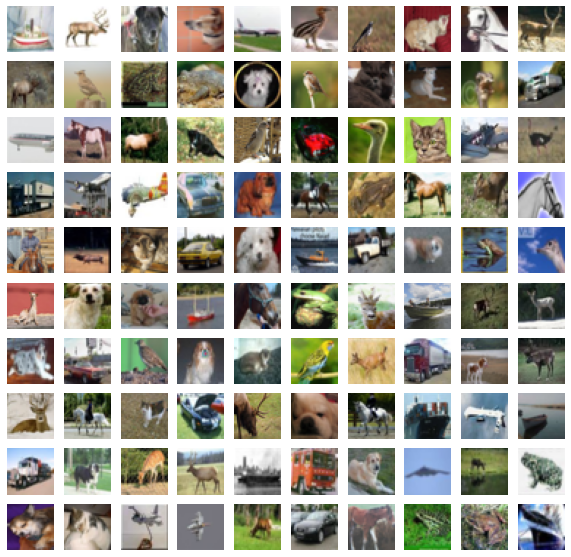

In [9]:
indices = np.random.choice(train_data.shape[0], 100)
sample_images(train_data[indices], 10, 10)

In [10]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [12]:
augmentation_layer.layers[0].adapt(train_data)

**Creating MLP**

multi layer perceptron

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**Splitting into patches**

these will act as our sequence tokens

In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(32, 32, 3)
(1, 72, 72, 3)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


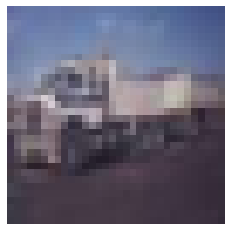

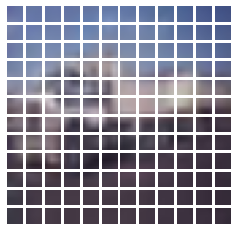

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = train_data[np.random.choice(range(train_data.shape[0]))]
print(image.shape)
plt.imshow(np.squeeze(image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Patch encoder layer**

adds positional embedding

In [15]:
class PatchEncoder(layers.Layer):
    
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
        

Model

In [16]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)
    
    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads, 
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = layers.Add()([attention_output, encoder_patches])
        
        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)
        
        # Skip Connnection 2
        encoder_patches = layers.Add()([x3, x2])
    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)
    
    outputs = layers.Dense(Config.num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
#vit_classifier.summary()

Train

In [18]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [20]:
history = vit_classifier.fit(train_data, train_labels, epochs=5, batch_size=Config.batch_size, validation_data=(test_data, test_labels), callbacks=[checkpoint])

Epoch 1/5
196/196 [==============================] - 77s 393ms/step - loss: 1.5665 - accuracy: 0.4363 - val_loss: 1.2548 - val_accuracy: 0.5507
Epoch 2/5
196/196 [==============================] - 76s 386ms/step - loss: 1.3754 - accuracy: 0.5104 - val_loss: 1.1785 - val_accuracy: 0.5812
Epoch 3/5
196/196 [==============================] - 76s 386ms/step - loss: 1.2647 - accuracy: 0.5535 - val_loss: 1.1155 - val_accuracy: 0.6028
Epoch 4/5
196/196 [==============================] - 76s 385ms/step - loss: 1.1803 - accuracy: 0.5821 - val_loss: 1.0503 - val_accuracy: 0.6286
Epoch 5/5
196/196 [==============================] - 76s 386ms/step - loss: 1.1145 - accuracy: 0.6089 - val_loss: 0.9747 - val_accuracy: 0.6563


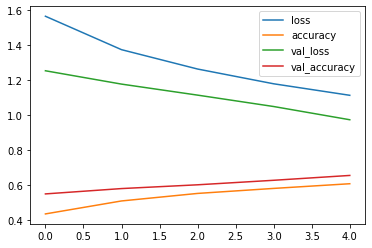

In [21]:
pd.DataFrame(history.history).plot()